In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv")
df.index = df["Date"]
del df["Date"]
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


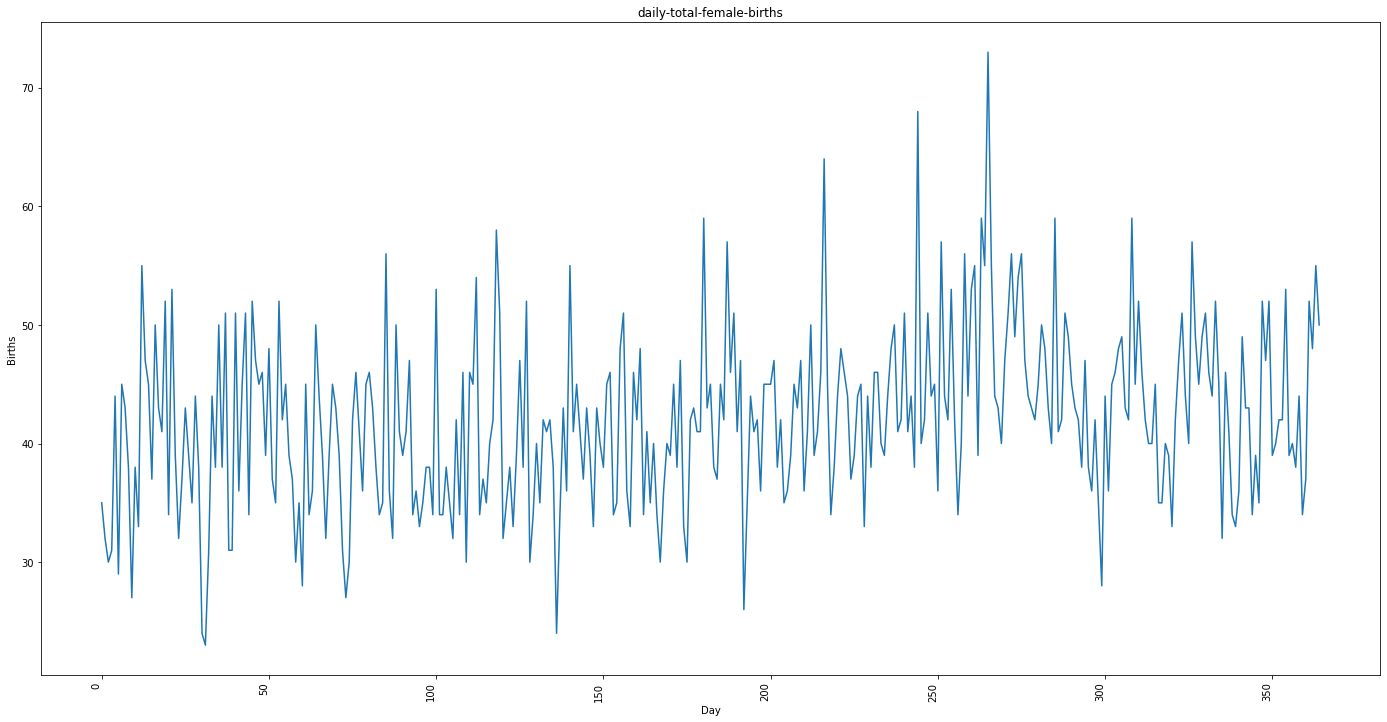

In [3]:
figure = plt.figure(figsize=(24,12))
plt.xticks(rotation=90, ha='right')
plt.title("daily-total-female-births")
plt.xlabel("Day")
plt.ylabel("Births")
plt.plot(range(len(df)), df)
plt.savefig("Births.png")
plt.show()

In [4]:
result = adfuller(df['Births'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.808291253559764
p-value: 5.2434129901498554e-05
Critical Values:
	1%: -3.448748905151901
	5%: -2.8696473721448728
	10%: -2.5710891239349585


/home/mag/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


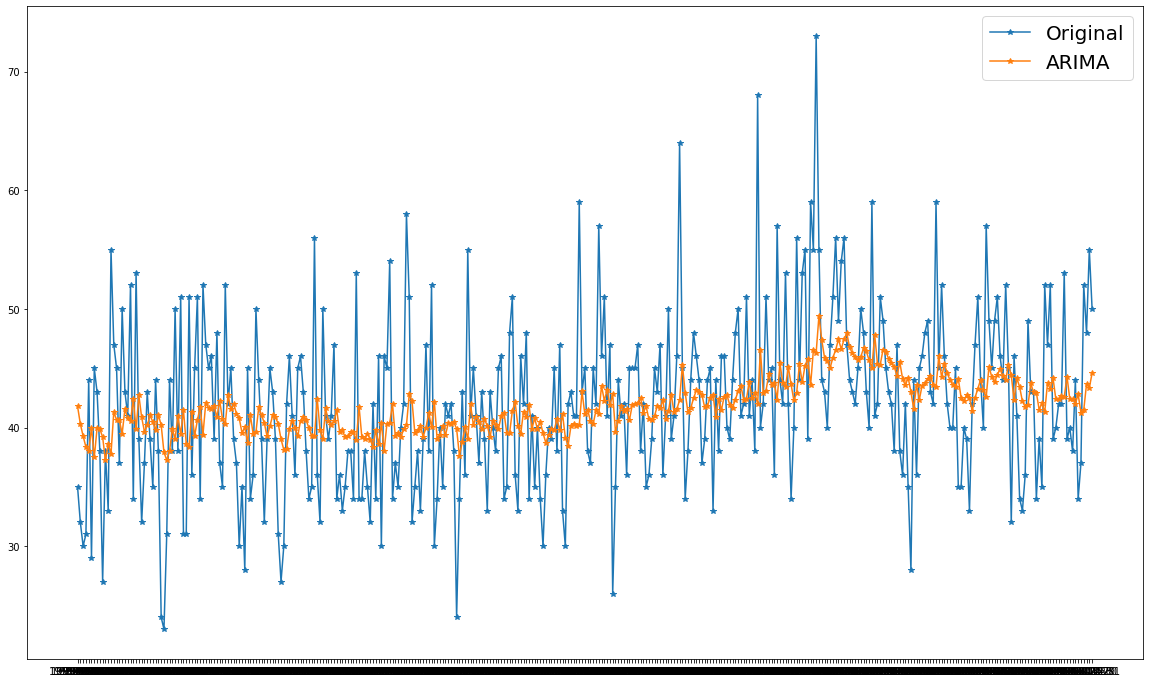

In [5]:

model = ARIMA(df["Births"], order=(2,0,1))
results = model.fit(disp=-1)
figure = plt.figure(figsize=(20,12))
plt.plot(df["Births"].index,df["Births"],"-*", label="Original")
plt.plot(results.fittedvalues,"-*", label="ARIMA")
plt.legend(loc = 'best', prop={'size': 20})
plt.show()

In [6]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
class Anfis:

    def __init__(self, J=7, epoch=100, lr_1=0.5, lr_2=0.5):
        
        self.lr_1 = lr_1
        self.lr_2 = lr_2
        self.epoch = epoch
        self.J = J
        
        
    def f(self, j, X, t):
        return np.dot(np.concatenate((X[t],[1])),self.b[:,j])


    def mu(self, i, j, X, t):
        return np.exp(-((X[t][i]-self.m[i][j])/self.sigma[i][j])**2)

    def alfa(self,j, X, t):
        prod = 1
        for i in range(len(X[t])):
            prod *= self.mu(i,j, X, t) 
        
        return prod
    
    def train(self, X, Y):
        self.m = np.zeros((X.shape[1], self.J))
        self.sigma = np.ones((X.shape[1], self.J))
        self.b = np.ones((X.shape[1]+1, self.J))
        errores_salida = []
        for t in range(self.epoch):
            
            salida = []

            a = np.ones((X.shape[0], self.J))
            errores = []
            for i in range(X.shape[0]):

                for j in range(self.J):
                    summ = []
                    for k in range(j+1):
                        summ.append(self.alfa(k,X,i))

                    a[i][j] = self.alfa(j,X,i)/sum(summ)

                resultado = 0
                for j in range(self.J):
                    resultado += a[i][j]*self.f(j,X,i)

                salida.append(resultado)
                errores.append((resultado-Y[i])**2)
               

            p = []
            for i in range(X.shape[0]):
                s = np.concatenate(([1] ,X[i]))
                for j in range(1, self.J):
                    s = np.concatenate((s,np.concatenate(([1] ,X[i]))))
                s.reshape(self.J*(X.shape[1]+1))

                p.append(s)
            p = np.array(p) 

            Aux = np.ones((X.shape[0], self.J*(X.shape[1]+1)))

            for i in range(X.shape[0]):
                aux = np.full(X.shape[1]+1,a[0][0])
                for j in range(1, self.J):
                    aux = np.concatenate((aux,np.full(X.shape[1]+1,a[i][j])))
                Aux[i] = aux

            A = np.multiply(Aux,p)
            inverse = np.dot(A.T, A)
            if np.linalg.det(inverse)==0:        
                self.b = np.dot(np.linalg.pinv(inverse),np.dot(A.T,Y))
            else:
                self.b = np.dot(np.linalg.inv(inverse),np.dot(A.T,Y))
            self.b = self.b.reshape(X.shape[1]+1, self.J)
            

            derivada_m = np.zeros((X.shape[1], self.J))
            derivada_sigma = np.zeros((X.shape[1], self.J))

            for i in range(X.shape[1]):
                for j in range(self.J):
                    sum_m = 0
                    sum_sigma = 0
                    for v in range(X.shape[1]):
                        sum_m +=  (salida[v]-Y[v])*a[v][j]*((self.f(j,X,v)-Y[v])*(X[1][v]-self.m[i][j])/self.sigma[i][j]**2)
                        sum_sigma +=  (salida[v]-Y[v])*a[v][j]*((self.f(j,X,v)-Y[v])*(X[1][v]-self.m[i][j])**2/self.sigma[i][j]**3)
                    derivada_m[i][j] = 2/X.shape[0] * sum_m
                    derivada_sigma[i][j] = 2/X.shape[0] * sum_sigma


            for i in range(X.shape[1]):
                for j in range(self.J):
                    self.m[i][j] -= self.lr_1*derivada_m[i][j]
                    self.sigma[i][j] -= self.lr_2* derivada_sigma[i][j]
            
            errores_salida.append(sum(errores)/len(errores))
        return np.array(errores_salida)
    
    def predict(self, X):
        
        salida = []

        a = np.ones((X.shape[0], self.J))
        errores = []
        for i in range(X.shape[0]):

            for j in range(self.J):
                summ = []
                for k in range(j+1):
                    summ.append(self.alfa(k,X,i))

                a[i][j] = self.alfa(j,X,i)/sum(summ)

            resultado = 0
            for j in range(self.J):
                resultado += a[i][j]*self.f(j,X,i)

            salida.append(resultado)
            
        return np.array(salida)

In [8]:
df_anfis = series_to_supervised(df, n_out=3)
df_anfis.rename(columns={"var1(t-1)":"t", "var1(t)":"t+1", "var1(t+1)":"t+2", "var1(t+2)":"t+3"}, inplace=True)
df_anfis

,t,t+1,t+2,t+3
Date,,,,
1959-01-02,35.0,32,30.0,31.0
1959-01-03,32.0,30,31.0,44.0
1959-01-04,30.0,31,44.0,29.0
1959-01-05,31.0,44,29.0,45.0
1959-01-06,44.0,29,45.0,43.0
...,...,...,...,...
1959-12-25,38.0,44,34.0,37.0
1959-12-26,44.0,34,37.0,52.0
1959-12-27,34.0,37,52.0,48.0


In [9]:
X = df_anfis[["t", "t+1", "t+2"]].values
Y = df_anfis["t+3"].values


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [10]:
model2 = Anfis(J=5, epoch=50, lr_1=4.9, lr_2=0.9)
n = 300
errores_anfis = model2.train(X[:n],Y[:n])
errores_anfis

array([1.63977621e+03, 2.65230609e+03, 4.86869331e+11, 1.39228292e+16,
       9.81068674e+18, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03, 2.23797358e+03, 2.23797358e+03,
       2.23797358e+03, 2.23797358e+03])

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 


    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
p = 0.02
combinado = p * results.fittedvalues[3:-3] + (1-p) * model2.predict(X)[3:]*0.18 + 42

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(10)


# create and fit the LSTM network
model3 = Sequential()
model3.add(Dense(8, input_shape=X[:n].shape))
model3.add(Dense(5))
model3.add(Dense(3))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
errores_ann = model3.fit(X[:n], Y[:n], epochs=200)

Epoch 1/200
10/10 [==============================] - 0s 4ms/step - loss: 1793.0248
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 1779.9048
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 1767.0162
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 1754.0850
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 1740.4464
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 1725.7870
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 1709.8917
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 1692.4232
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 1672.7902
Epoch 10/200
10/10 [==============================] - 0s 2ms/step - loss: 1651.2993
Epoch 11/200
10/10 [==============================] - 0s 2ms/step - loss: 1626.7930
Epoch 12/200
10/10 [==============================] - 0s 3ms/step - loss: 1599.1484
E

10/10 [==============================] - 0s 3ms/step - loss: 52.5926
Epoch 96/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6242
Epoch 97/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6774
Epoch 98/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6318
Epoch 99/200
10/10 [==============================] - 0s 1ms/step - loss: 52.6394
Epoch 100/200
10/10 [==============================] - 0s 1ms/step - loss: 52.5799
Epoch 101/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6148
Epoch 102/200
10/10 [==============================] - 0s 1ms/step - loss: 52.6180
Epoch 103/200
10/10 [==============================] - 0s 1ms/step - loss: 52.6786
Epoch 104/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6426
Epoch 105/200
10/10 [==============================] - 0s 1ms/step - loss: 52.7799
Epoch 106/200
10/10 [==============================] - 0s 1ms/step - loss: 52.6587
Epoch 107/200
10/10 [=

10/10 [==============================] - 0s 1ms/step - loss: 52.7222
Epoch 194/200
10/10 [==============================] - 0s 2ms/step - loss: 52.6265
Epoch 195/200
10/10 [==============================] - 0s 1ms/step - loss: 52.5992
Epoch 196/200
10/10 [==============================] - 0s 2ms/step - loss: 52.7248
Epoch 197/200
10/10 [==============================] - 0s 2ms/step - loss: 52.5638
Epoch 198/200
10/10 [==============================] - 0s 1ms/step - loss: 52.7323
Epoch 199/200
10/10 [==============================] - 0s 2ms/step - loss: 52.5822
Epoch 200/200
10/10 [==============================] - 0s 3ms/step - loss: 52.6420


In [14]:
print(mean_absolute_percentage_error(df["Births"][303:-3], combinado[300:]))
print(mean_absolute_percentage_error(df["Births"][303:-3], results.fittedvalues[303:-3]))
#print(mean_absolute_percentage_error(df["Births"][300:-3], (model2.predict(X)*0.18 + 42)[300:]))
print(mean_absolute_percentage_error(df["Births"][303:-3], model3.predict(X)[303:].reshape(1,-1)[0]))

6.1675835659236675
11.556586483302251
10.687840760284628


In [15]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(df["Births"][303:-3], combinado[300:]))
print(mean_absolute_error(df["Births"][303:-3], results.fittedvalues[303:-3]))
#print(mean_absolute_error(df["Births"][300:-3], (model2.predict(X)*0.18 + 42)[300:]))
print(mean_absolute_error(df["Births"][303:-3], model3.predict(X)[303:].reshape(1,-1)[0]))

2.5616301322538044
4.902728972916061
4.605902526338221


In [16]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df["Births"][303:-3], combinado[300:]))
print(mean_squared_error(df["Births"][303:-3], results.fittedvalues[303:-3]))
#print(mean_squared_error(df["Births"][300:-3], (model2.predict(X)*0.18 + 42)[300:]))
print(mean_squared_error(df["Births"][303:-3], model3.predict(X)[303:].reshape(1,-1)[0]))

9.803684010569883
38.494302976194746
31.998833694802823


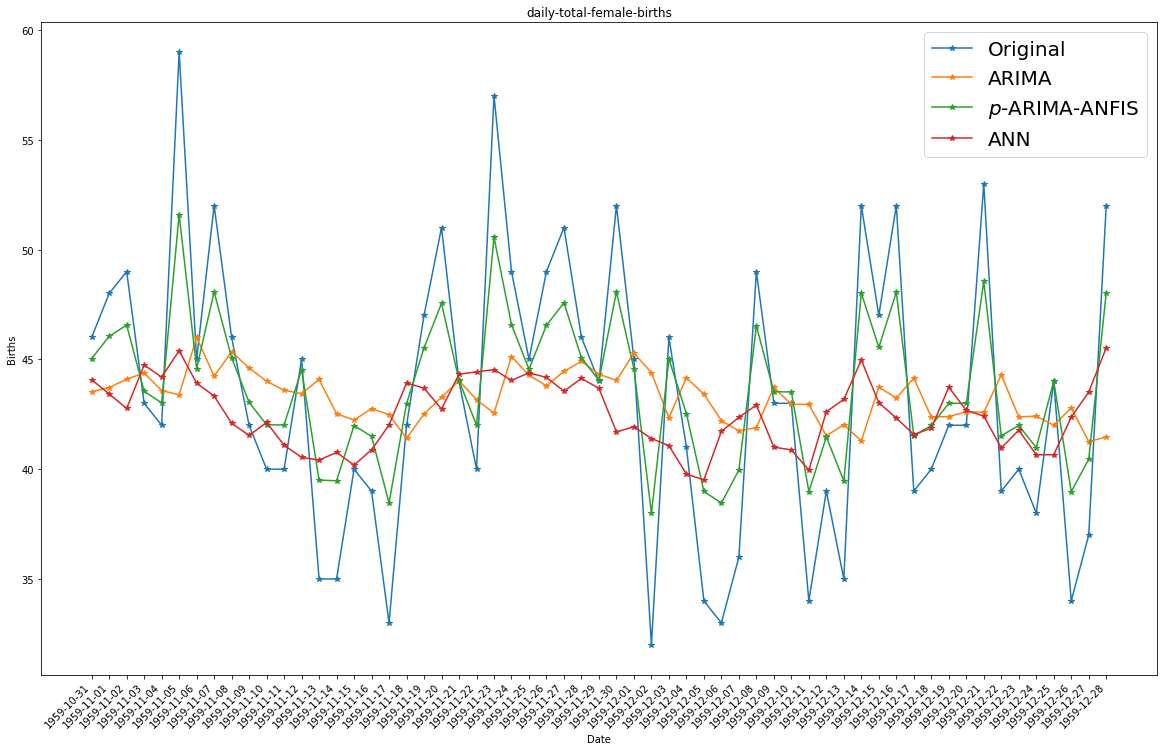

In [17]:
figure = plt.figure(figsize=(20,12))
plt.title("daily-total-female-births")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Births")
plt.plot(df["Births"][n+3:-3],"-*", label="Original")
plt.plot(results.fittedvalues[n+3:-3],"-*", label="ARIMA")
plt.plot(combinado[n:], "-*", label="$p$-ARIMA-ANFIS")
plt.plot(model3.predict(X[n+3:]).reshape(1,-1)[0], "-*", label="ANN")
plt.legend(loc = 'best', prop={'size': 20})
plt.savefig("figura1.png")
plt.show()